#Step 1: Import Libraries

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras import layers
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, GlobalAveragePooling2D
import numpy as np
import matplotlib.pyplot as plt
import cv2


# Step 2: Load and Preprocess Data

In [ ]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!unzip -q kagglecatsanddogs_5340.zip
!ls


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  94.9M      0  0:00:08  0:00:08 --:--:--  119M
 CDLA-Permissive-2.0.pdf   kagglecatsanddogs_5340.zip   PetImages  'readme[1].txt'   sample_data


# Filter out corrupted Images

In [ ]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            os.remove(fpath)

print("Deleted %d images" % num_skipped)


Deleted 1590 images


# Generate Dataset

In [ ]:
image_size = (300, 300)
batch_size = 128

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


# Visualize Data

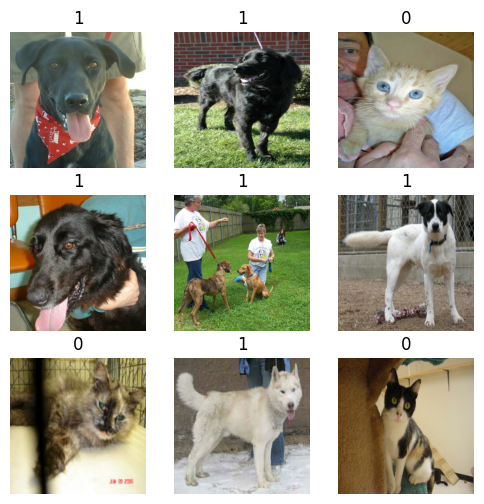

In [ ]:
plt.figure(figsize=(6, 6))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


# Step 4: Data Augmentation

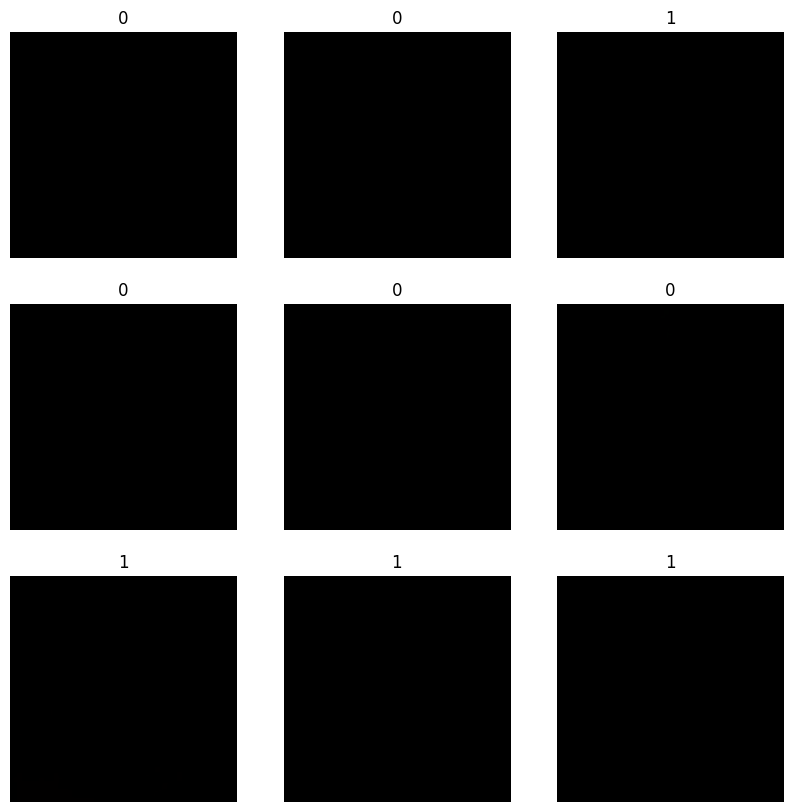

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt


# Define the data augmentation pipeline
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])

# Augment and normalize the images
def augment_images(image, label):
    image = tf.cast(image, tf.float32)
    image = (image / 255.0)  # Normalize to [0, 1] range
    image = data_augmentation(image)
    return image, label

augmented_train_ds = train_ds.map(augment_images, num_parallel_calls=tf.data.AUTOTUNE)

# Visualize the augmented data
plt.figure(figsize=(10, 10))
for images, labels in augmented_train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.show()



# Step 5: Configure Dataset for Performance

In [ ]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)


#Step 6: Build the Classifier

In [ ]:
class CustomModel(Sequential):
    def __init__(self):
        super(CustomModel, self).__init__()

        self.add(Conv2D(16, input_shape=(300, 300, 3), kernel_size=(3, 3), activation='relu', padding='same'))
        self.add(MaxPooling2D(pool_size=(2, 2)))

        self.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
        self.add(MaxPooling2D(pool_size=(2, 2)))

        self.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
        self.add(MaxPooling2D(pool_size=(2, 2)))

        self.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
        self.add(GlobalAveragePooling2D())
        self.add(Dense(1, activation='sigmoid'))

model = CustomModel()
model.summary()


Model: "custom_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 150, 150, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 37, 37, 64)       

#Step 7: Compile and Train the Model

In [ ]:
model.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer=tf.keras.optimizers.RMSprop(lr=0.001))

model.fit(train_ds, epochs=25, validation_data=val_ds)


Epoch 1/25
147/147 [==============================] - 2443s 17s/step - loss: 1.4475 - accuracy: 0.5153 - val_loss: 0.7315 - val_accuracy: 0.5066
Epoch 2/25
147/147 [==============================] - 2448s 17s/step - loss: 0.6910 - accuracy: 0.5537 - val_loss: 0.6694 - val_accuracy: 0.5651
Epoch 3/25
147/147 [==============================] - 2384s 16s/step - loss: 0.6688 - accuracy: 0.5892 - val_loss: 0.6412 - val_accuracy: 0.6207
Epoch 4/25
111/147 [=====================>........] - ETA: 9:01 - loss: 0.6478 - accuracy: 0.6213

# Step 8: Test the Model


In [ ]:
!wget -O cat1.jpg https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/cat1.jpg
!wget -O cat2.jpg https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/cat2.jpg
!wget -O catanddog.jpg https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/catanddog.jpg
!wget -O dog1.jpg https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/dog1.jpg
!wget -O dog2.jpg https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/dog2.jpg

# Load and preprocess images
image = tf.keras.preprocessing.image.load_img('/tmp/cat1.jpg', target_size=(300, 300))
image_arr = tf.keras.preprocessing.image.img_to_array(image)
image_arr = tf.expand_dims(image_arr, 0)

# Make predictions
prediction = model.predict(image_arr)
print(prediction)
